In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
import datetime as dt

In [3]:
# FUNCTION: Fetch historical price data using yfinance
def fetch_data(tickers, start_date, end_date):
    data = {}
    successful = 0
    failed = 0

    for i, ticker in enumerate(tickers):
        try:
            print(f'Fetching {ticker} ({i+1}/{len(tickers)})...', end='\r')
            stock = yf.Ticker(ticker)
            df = stock.history(start=start_date, end=end_date)

            if df.empty:
                print(f'No data for {ticker}.')
                data[ticker] = None
                failed += 1
            else:
                data[ticker] = df
                successful += 1
                # print(f'Fetch successful for {ticker}!')

        # For debugging purposes:
        except Exception as error:
            print(f'Failed to fetch data for {ticker} with error: {error}')
            data[ticker] = None
            failed += 1

    print(f'\nSuccessful: {successful}\nFailed: {failed}')
    return data

In [4]:
# FUNCTION: Check fetched data info for stocks: (Mainly used for debugging)
def check_fetched_data(data):
    for ticker in data:
        df = data[ticker]
        if df is not None:
            print(f'Data info for {ticker}:')
            df.info()
            print('\n' + '='*50 + '\n') # Seperator
        else:
            print(f'No data available for {ticker}.\n')
    return 

In [5]:
# Parameters for fetching data
tickers = ['AAPL', 'NVDA', 'GOOG', 'META']
start_date = '2013-01-01'
end_date = dt.datetime.today().strftime('%Y-%m-%d')

In [6]:
# Fetch data
data=fetch_data(tickers, start_date, end_date)

Fetching META (4/4)...
Successful: 4
Failed: 0


In [7]:
data

{'AAPL':                                  Open        High         Low       Close  \
 Date                                                                        
 2013-01-02 00:00:00-05:00   16.792419   16.828198   16.422806   16.647181   
 2013-01-03 00:00:00-05:00   16.612313   16.666588   16.403704   16.437057   
 2013-01-04 00:00:00-05:00   16.281509   16.331843   15.943732   15.979208   
 2013-01-07 00:00:00-05:00   15.827601   16.048945   15.621418   15.885212   
 2013-01-08 00:00:00-05:00   16.046214   16.127475   15.804859   15.927961   
 ...                               ...         ...         ...         ...   
 2025-07-18 00:00:00-04:00  210.869995  211.789993  209.699997  211.179993   
 2025-07-21 00:00:00-04:00  212.100006  215.779999  211.630005  212.479996   
 2025-07-22 00:00:00-04:00  213.139999  214.949997  212.229996  214.399994   
 2025-07-23 00:00:00-04:00  215.000000  215.149994  212.410004  214.149994   
 2025-07-24 00:00:00-04:00  213.899994  215.690002  213.

In [8]:
# Check data if any issues
check_fetched_data(data)

Data info for AAPL:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3159 entries, 2013-01-02 00:00:00-05:00 to 2025-07-24 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3159 non-null   float64
 1   High          3159 non-null   float64
 2   Low           3159 non-null   float64
 3   Close         3159 non-null   float64
 4   Volume        3159 non-null   int64  
 5   Dividends     3159 non-null   float64
 6   Stock Splits  3159 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 197.4 KB


Data info for NVDA:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3159 entries, 2013-01-02 00:00:00-05:00 to 2025-07-24 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3159 non-null   float64
 1   High          3159 non-null   float64
 2   Low           3159 non-null   floa

In [9]:
# FUNCTION: Plot price chart for fetched data
def plot_price_chart(data, start_date, end_date):
    for ticker in tickers:
        df = data[ticker]
        df['Close'].plot(title=f'{ticker} Stock Price', figsize=(7, 4))
        plt.xlabel(f'Date Range: {start_date} - {end_date}')
        plt.ylabel('Close Price (USD)')
        plt.tight_layout()
        plt.show()
    return

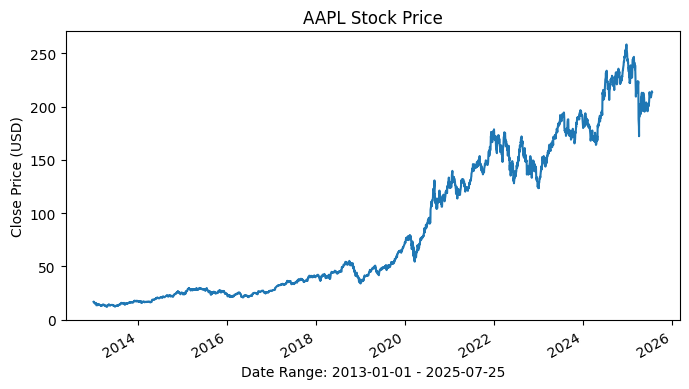

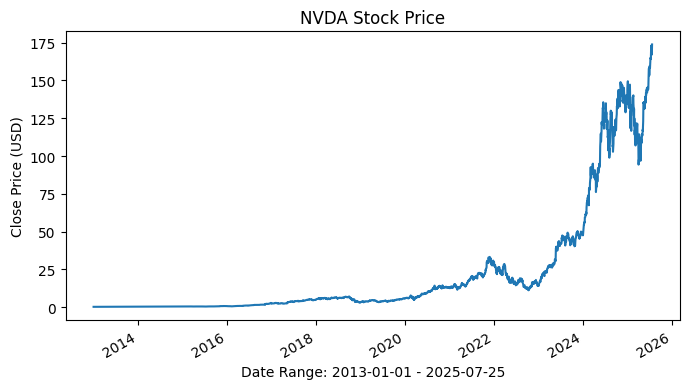

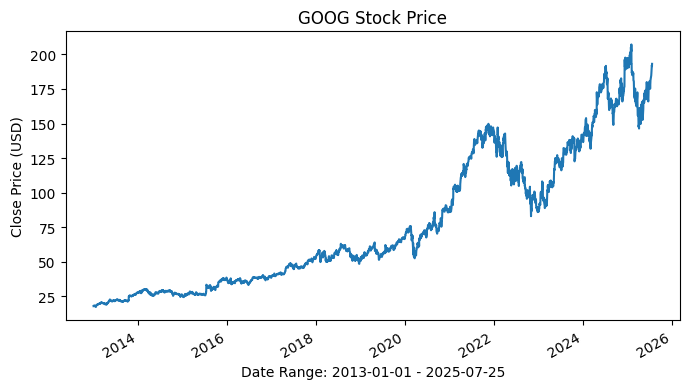

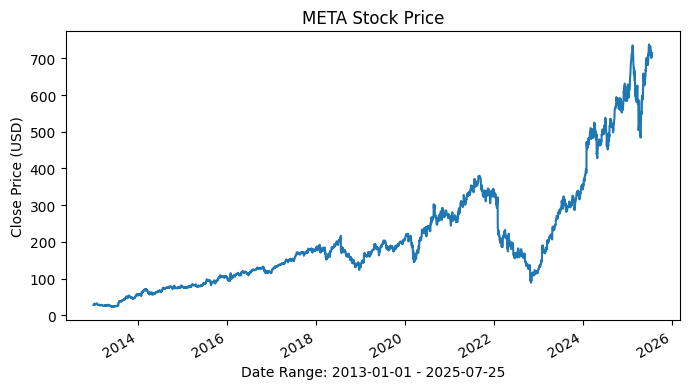

In [10]:
plot_price_chart(data,start_date,end_date)

In [11]:
# FUNCTION: RSI Indicator
def rsi_indicator(data, window=14):
    df = data.copy()
    delta = df['Close'].diff() # Difference between consecutive closing prices of tickers
    avg_gain = delta.where(delta > 0, 0).rolling(window=window, min_periods=1).mean() # min_periods=1 to avoid NaNs at the start
    avg_loss = -delta.where(delta < 0, 0).rolling(window=window, min_periods=1).mean()
    avg_loss = avg_loss.replace(0, 1e-10) # Prevent division by zero
    rs = avg_gain / avg_loss
    rsi = 100-(100/(1+rs))
    df['RSI'] = rsi
    return df

![RSI](https://www.alpharithms.com/wp-content/uploads/1674/rsi-formulae-alpharithms-1024x576.jpg)

In [13]:
# FUNCTION: MACD Indicator
def macd_indicator(data, fast=12, slow=26, signal=9):
    df = data.copy()
    fast_ema = df['Close'].ewm(span=fast).mean()
    slow_ema = df['Close'].ewm(span=slow).mean()
    df['MACD'] = fast_ema - slow_ema
    df['MACD_Line'] = df['MACD'].ewm(span=signal).mean()
    df['MACD_Histogram'] = df['MACD'] - df['MACD_Line']
    return df

![MACD](https://www.alpharithms.com/wp-content/uploads/1329/macd-trigger-formulas-alpharithms.jpg)

In [21]:
# FUNCTION: Buy / Sell signals generated from RSI indicator
def rsi_signal(data, min=30, max=70):
    df = data.copy()
    rsi = df['RSI']
    if 'RSI' not in df.columns:
        raise KeyError("RSI column is missing!")

    # Discrete signals: nil, 1: buy, -1: sell
    df['RSI_Signal'] = 0
    df.loc[df['RSI'] < min, 'RSI_Signal'] = 1 # buy signal (oversold)
    df.loc[df['RSI'] > max, 'RSI_Signal'] = -1 # sell signal (overbought)

    # Continuous features (normalised)
    df['RSI_Oversold'] = np.maximum(0, min-rsi)/min
    df['RSI_Overbought'] = np.maximum(0, rsi-max)/(100-max)

    # Changes in RSI
    df['RSI_Change'] = rsi.diff()
    return df

In [38]:
def macd_signal(data):
    df = data.copy()
    hist = df['MACD_Histogram']
    if 'MACD_Histogram' not in df.columns:
        raise KeyError("MACD_Histogram column is missing!")

    # Discrete signals: Buy/Sell/Hold
    df['MACD_Signal'] = 0
    df.loc[(df['MACD_Histogram'] > 0) & (df['MACD_Histogram'].shift(1) <= 0), 'MACD_Signal'] = 1
    df.loc[(df['MACD_Histogram'] < 0) & (df['MACD_Histogram'].shift(1) >= 0), 'MACD_Signal'] = -1

    # Continuous features (normalised)
    max_abs_hist = hist.abs().rolling(window=20, min_periods=5).max().replace(0, 1e-10)
    df['MACD_Hist_Score'] = hist / max_abs_hist  # Normalized -1 to 1
    df['MACD_Hist_Direction'] = np.sign(hist.diff())  # +1 = rising, -1 = falling, 0 = flat

    return df


In [22]:
# FUNCTION: RSI Signal Plot
def rsi_signal_plot(tickers, start_date, end_date, min=30, max=70):

    fig, axes = plt.subplots(nrows=len(tickers), ncols=2, figsize=(14, 7 * len(tickers)))
    for i, ticker in enumerate(tickers):
        df = data[ticker]
        
        if df is None:
            continue  # Skip if data is missing for a stock
        
        df = rsi_indicator(df)
        
        # Plot RSI with overbought and oversold levels
        axes[i, 0].plot(df.index, df['RSI'], label='RSI', color='blue')
        axes[i, 0].axhline(y=min, color='red', linestyle='--', label=f'Oversold ({min})')
        axes[i, 0].axhline(y=max, color='green', linestyle='--', label=f'Overbought ({max})')
        axes[i, 0].set_title(f'RSI (Relative Strength Index) for {ticker}')
        axes[i, 0].legend(loc='upper left')
        
        # Buy ('^') and sell ('v') signals in plot
        axes[i, 0].scatter(df.index[df['RSI'] < min], df['RSI'][df['RSI'] < min], color='green', label='Buy Signal', marker='^', alpha=1)
        axes[i, 0].scatter(df.index[df['RSI'] > max], df['RSI'][df['RSI'] > max], color='red', label='Sell Signal', marker='v', alpha=1)
        
        # Historical stock price plot
        axes[i, 1].plot(df.index, df['Close'], label='Close Price', color='black')
        buy_signals = df[df['RSI'] < min]
        axes[i, 1].scatter(buy_signals.index, buy_signals['Close'], color='green', marker='^', label='Buy Signal', alpha=1) # Plot Buy signals as makeshift green arrows on the stock price chart
        sell_signals = df[df['RSI'] > max]
        axes[i, 1].scatter(sell_signals.index, sell_signals['Close'], color='red', marker='v', label='Sell Signal', alpha=1) # Plot Sell signals as makeshift red arrows on the stock price chart
        axes[i, 1].set_title(f'Stock Close Price for {ticker}')
        axes[i, 1].legend(loc='upper left')

    plt.tight_layout()
    plt.show()
    return

In [32]:
# FUNCTION: MACD Signal Plot
def macd_signal_plot(tickers, start_date, end_date):
    fig, axes = plt.subplots(nrows=len(tickers), ncols=2, figsize=(14, 7*len(tickers)))
    for i, ticker in enumerate(tickers):
        df = data[ticker]
        if df is None:
            continue # Skip if data is missing for a stock

        df = macd_indicator(df)

        # Plot MACD and Signal Line
        axes[i, 0].plot(df.index, df['MACD'], label='MACD', color='blue')
        axes[i, 0].plot(df.index, df['MACD_Line'], label='Signal Line', color='red')
        axes[i, 0].set_title(f'MACD and Signal Line for {ticker}')
        axes[i, 0].legend(loc='upper left')

        # Plot MACD Histogram
        axes[i, 1].bar(df.index, df['MACD_Histogram'], color='gray', label='MACD Histogram')
        axes[i, 1].axhline(0, color='black', linewidth=1)  # Zero line for reference
        axes[i, 1].set_title(f'MACD Histogram for {ticker}')
        axes[i, 1].legend(loc='upper left')

    plt.tight_layout()
    plt.show()
    return

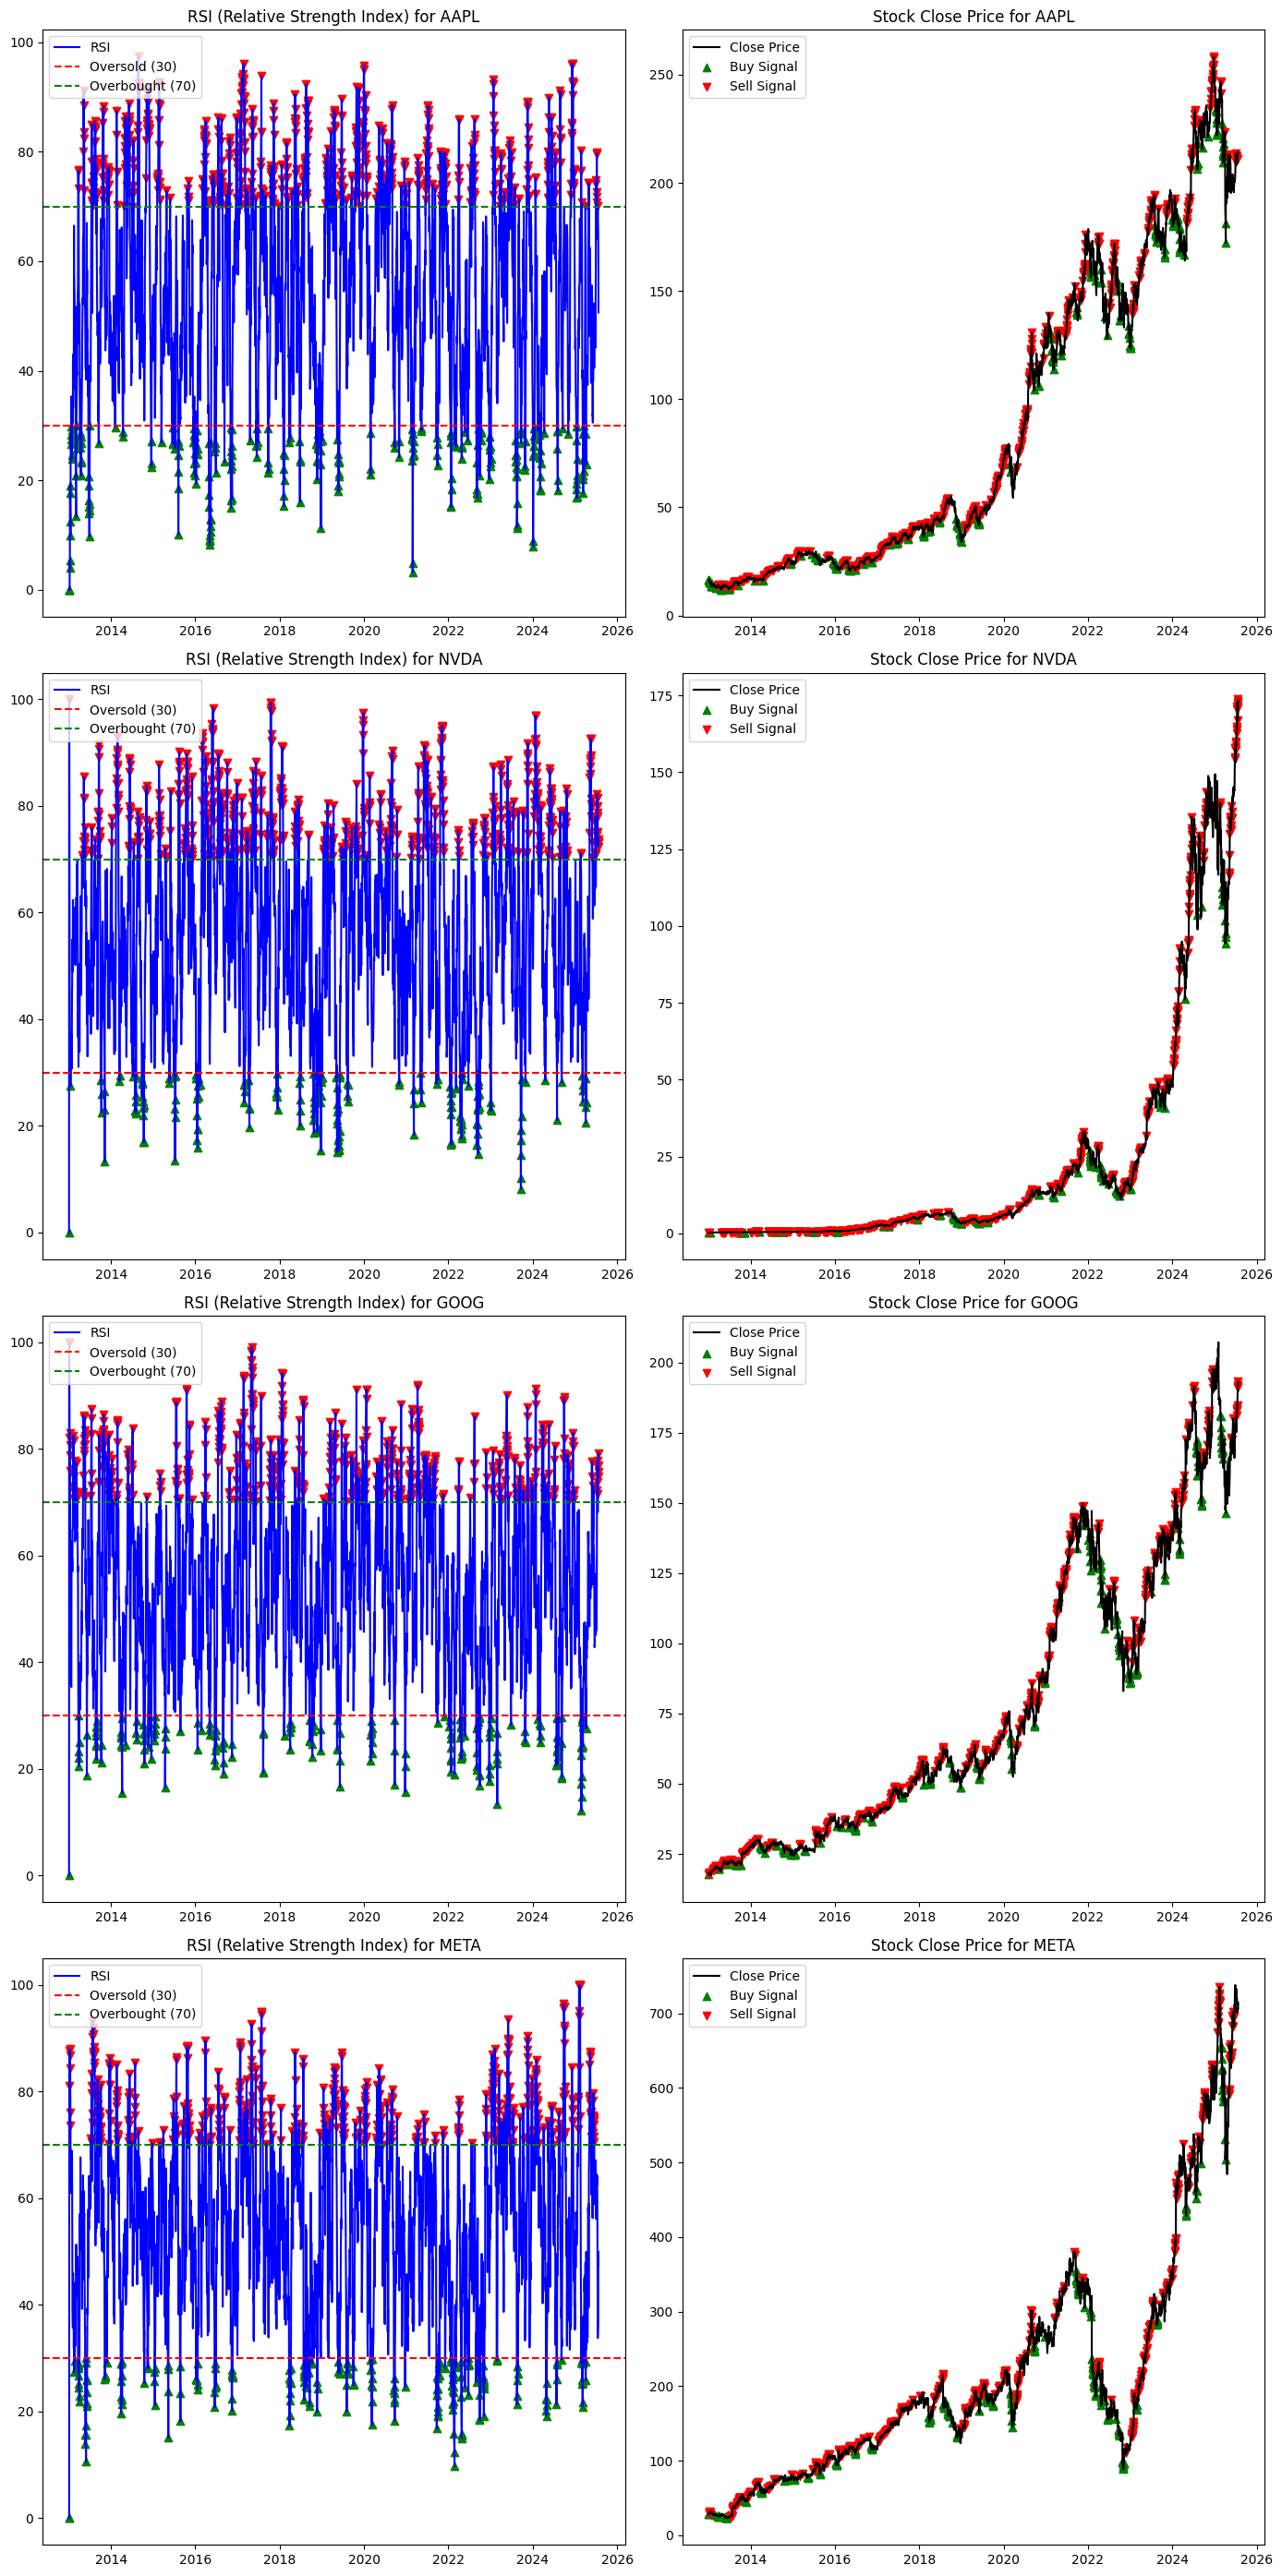

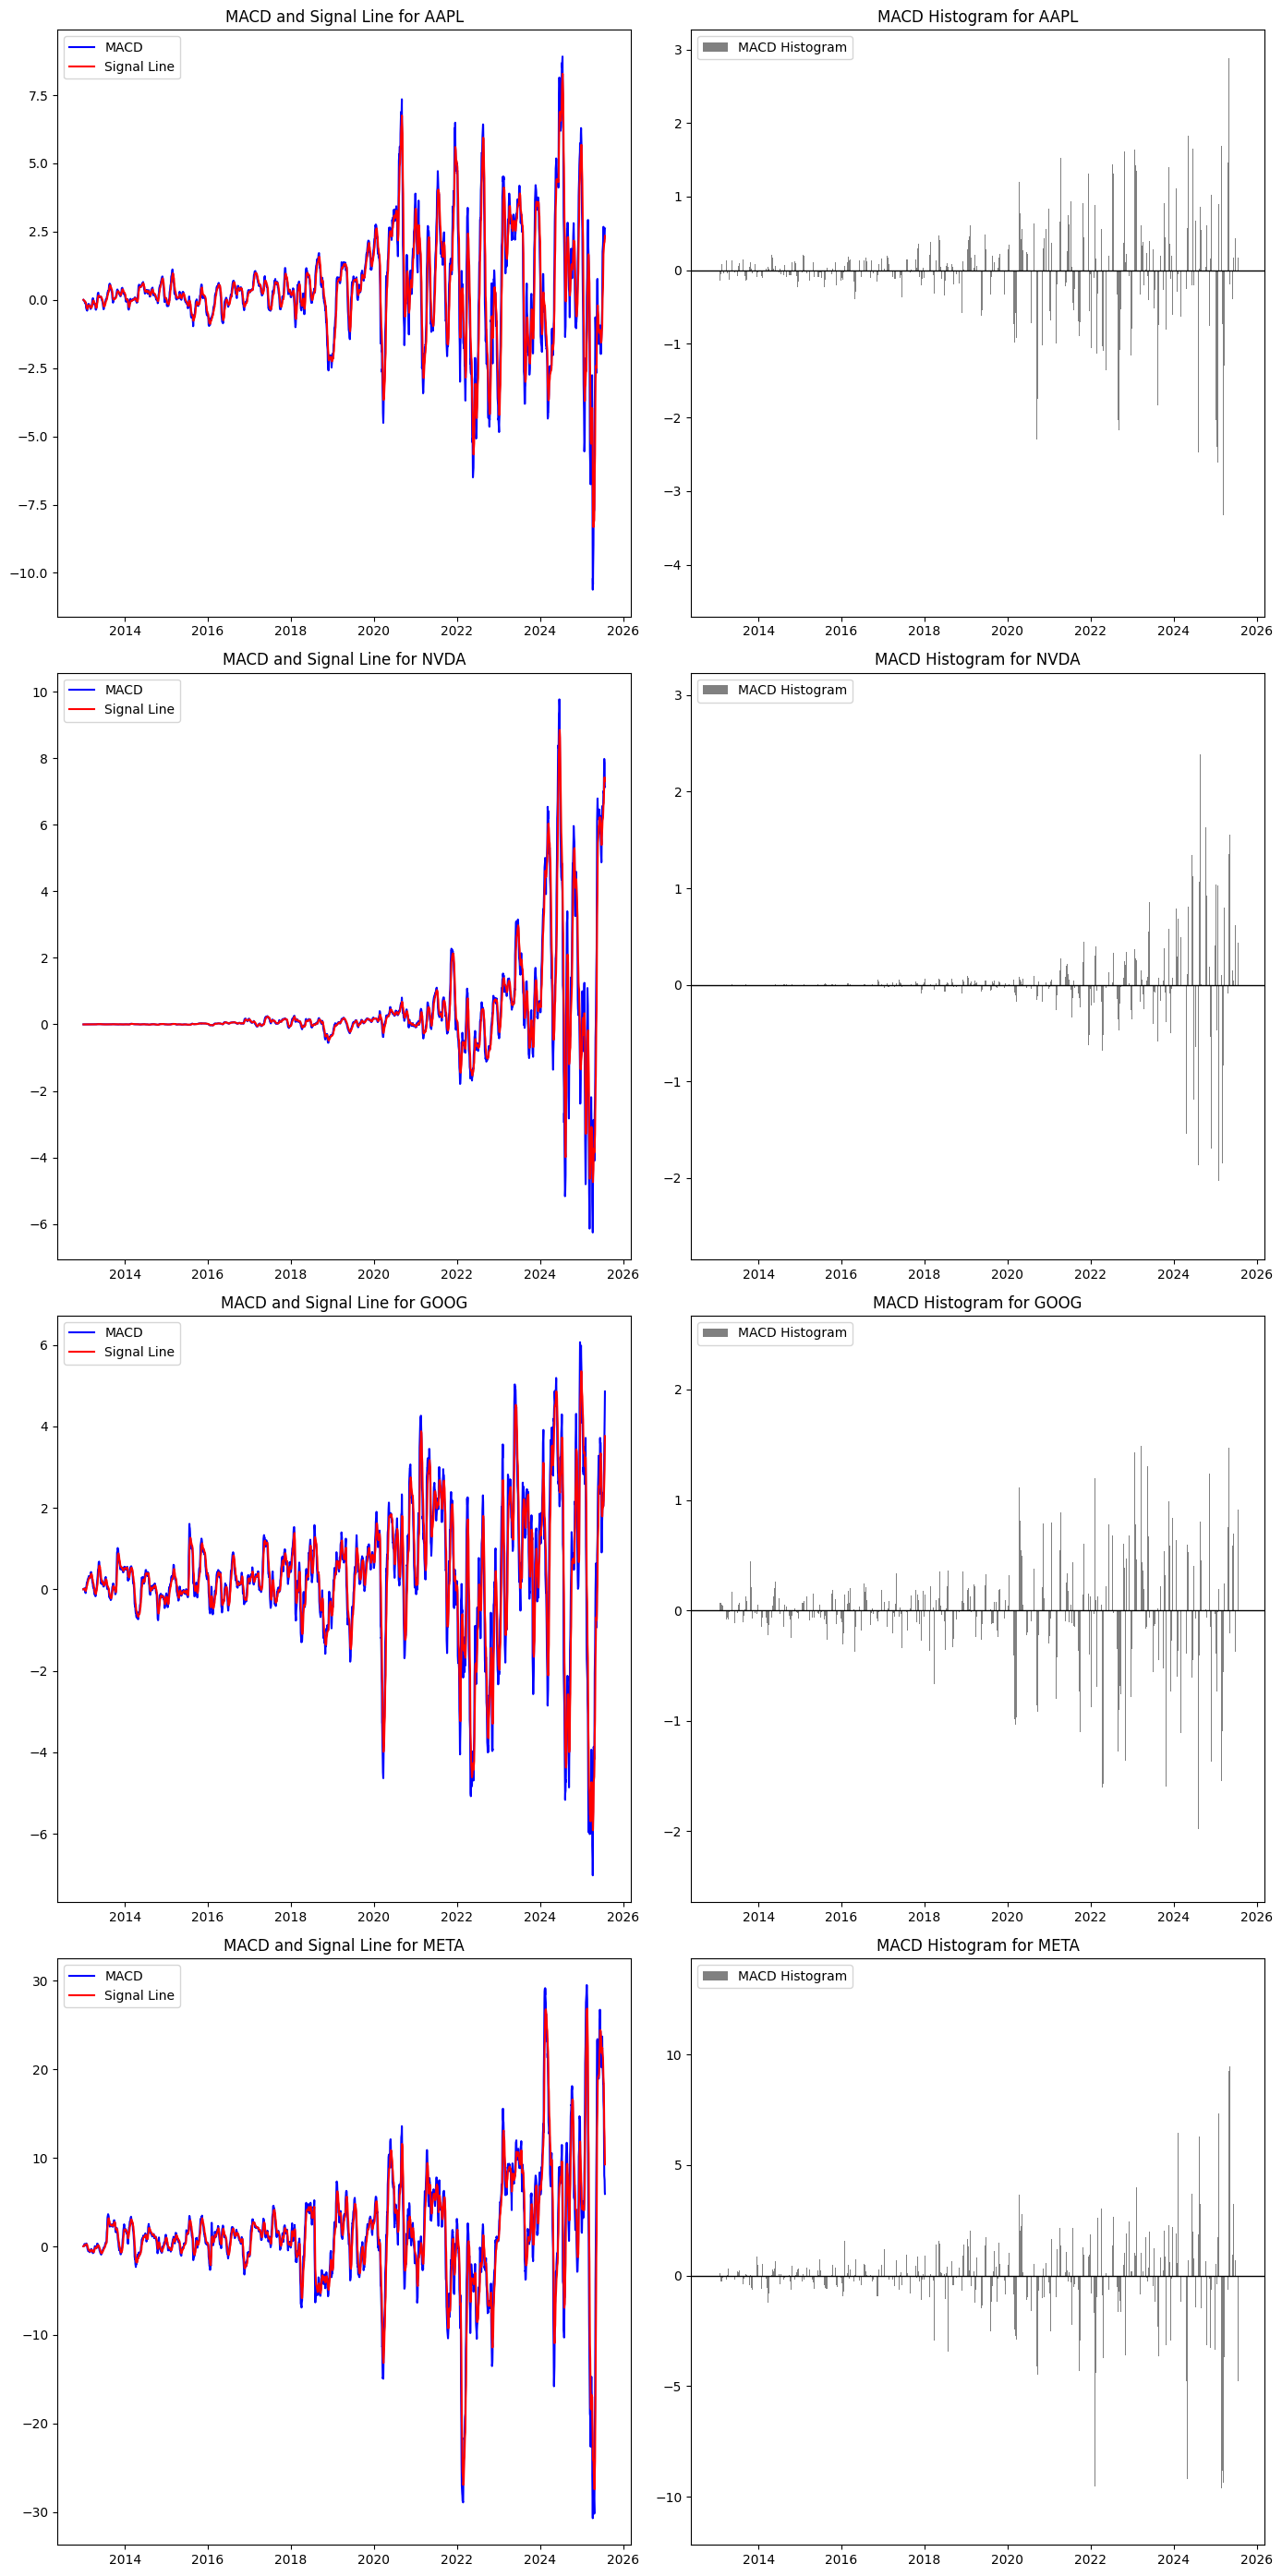

In [18]:
# Parameters for fetching data
tickers = ['AAPL', 'NVDA', 'GOOG', 'META']
start_date = '2013-01-01'
end_date = dt.datetime.today().strftime('%Y-%m-%d')

# Plot RSI & MACD signals for all stocks
rsi_signal_plot(tickers, start_date, end_date)
macd_signal_plot(tickers, start_date, end_date)

In [24]:
# FUNCTION: Backtesting pipeline
def backtest_pipeline(data, initial_capital=100_000):
    df = data.copy()
    if 'RSI_Signal' not in df.columns:
        raise KeyError("RSI Signal column is missing!")
    if 'MACD_Signal' not in df.columns:
        raise KeyError("MACD Signal column is missing!")
    
    # Initialise Parameters
    min_trade_value = initial_capital / len(tickers)  # Minimum trade value in dollars
    commission = 0.003
    slippage = 0.000
    transaction_costs = commission + slippage

    # Calculate combined signal (both RSI and MACD must agree)
    df['Combined_Signal'] = df['RSI_Signal'].shift(1).fillna(0) * df['MACD_Signal'].shift(1).fillna(0)
    
    # Calculate minimum shares needed for min_trade_value
    df['Min_Shares'] = (min_trade_value / df['Close']).round().astype(int)
    df['Position_Shares'] = df['Combined_Signal'] * df['Min_Shares']
    df['Position_Value'] = df['Position_Shares'] * df['Close']
    df['Mkt_Returns'] = df['Close'].pct_change().fillna(0)
    
    # Position changes
    df['Position_Change'] = df['Position_Shares'].diff().fillna(0)
    df['Trade_Occurred'] = (df['Position_Change'] != 0).astype(int)
    
    # Transaction costs
    df['Position_Value_Change'] = abs(df['Position_Change'] * df['Close'])
    df['Transaction_Costs'] = df['Position_Value_Change'] * transaction_costs
    
    # Calculate dollar returns
    df['Dollar_Returns'] = df['Position_Shares'] * df['Close'].diff().fillna(0) - df['Transaction_Costs']
    
    # Calculate percentage returns for portfolio
    df['Returns'] = df['Dollar_Returns'] / initial_capital
    df['Cumulative_Returns'] = (1 + df['Returns']).cumprod()
    df['Cumulative_Capital'] = initial_capital * df['Cumulative_Returns']

    return df

In [46]:
# FUNCTION: Metric calculation from backtest results
def backtest_metrics(returns):

    # Parameters
    trading_days = 252
    n_days = len(returns) # n parameter
    rfr = 0.002
    target_return = 0

    # Calculate returns
    total_return = np.prod(returns + 1) - 1
    annual_return = (1 + total_return) ** (trading_days / n_days) - 1 if (1 + total_return) > 0 else np.nan
    annual_volatility = np.std(returns) * np.sqrt(trading_days) # Sqrt(Variance * trading days)

    # Total number of trades
    total_trades = np.sum(returns != 0)

    # Average return per trade
    avg_trade_return = np.mean(returns[returns != 0]) if total_trades > 0 else np.nan

    # Max drawdown
    cumulative_returns = np.cumprod(returns + 1)
    ath_cumulative = np.maximum.accumulate(cumulative_returns)
    drawdown = (ath_cumulative - cumulative_returns) / ath_cumulative
    max_drawdown = np.max(drawdown)
    
    # Win / Loss
    win_trades = returns[returns > 0]
    win_rate = len(win_trades) / total_trades if total_trades > 0 else np.nan
    avg_win = np.mean(win_trades) if len(win_trades) > 0 else np.nan
    lose_trades = returns[returns < 0]
    lose_rate = len(lose_trades) / total_trades if total_trades > 0 else np.nan
    avg_lose = np.mean(lose_trades) if len(lose_trades) > 0 else np.nan

    # Expectancy
    expectancy = (win_rate * avg_win) + (lose_rate * avg_lose) if win_rate is not np.nan else np.nan


    # Calculate ratios:
    # Sharpe ratio
    sharpe_ratio = (annual_return - rfr) / annual_volatility 

    # Sortino ratio
    downside_returns = returns[returns < target_return]
    downside_volatility = np.std(downside_returns, ddof=1)
    annual_downside_volatility = downside_volatility * np.sqrt(trading_days) if len(downside_returns) > 0 else np.nan
    sortino_ratio = (annual_return - rfr) / annual_downside_volatility if annual_downside_volatility != 0 else np.nan

    return {
        "total_return": total_return,
        "annual_return": annual_return,
        "annual_volatility": annual_volatility,
        "max_drawdown": max_drawdown,
        "total_trades": total_trades,
        "average_return_per_trade": avg_trade_return if not np.isnan(avg_trade_return) else 'N/A',
        "win_rate": win_rate if not np.isnan(win_rate) else 'N/A',
        "expectancy": expectancy if not np.isnan(expectancy) else 'N/A',
        "sharpe_ratio": sharpe_ratio if not np.isnan(sharpe_ratio) else 'N/A',
        "sortino_ratio": sortino_ratio if not np.isnan(sortino_ratio) else 'N/A'
    }

In [62]:
# FUNCTION: Execute everything
def execute():
    # Parameters for fetching data
    tickers = ['AAPL', 'NVDA', 'GOOG', 'META']
    start_date = '2013-01-01'
    end_date = dt.datetime.today().strftime('%Y-%m-%d')

    # Running all functions - indicator, signal, backtest, metrics
    results = {}
    for ticker, df in data.items():
        if df is not None and not df.empty:
            df = rsi_indicator(df)
            df = macd_indicator(df)
            df = rsi_signal(df)
            df = macd_signal(df)
            backtest_results = backtest_pipeline(df)
            metric_results = backtest_metrics(backtest_results['Returns'])
            results[ticker] = metric_results

    # Results display
    results_data = {
        ticker: {
            'Total Return': f"{metric_results['total_return']:.2%}",
            'Annual Return': f"{metric_results['annual_return']:.2%}",
            'Annual Volatility': f"{metric_results['annual_volatility']:.2%}",
            'Maximum Drawdown': f"{metric_results['max_drawdown']:.2%}",
            'Total Trades': metric_results['total_trades'],
            'Average Return Per Trade': f"{metric_results['average_return_per_trade']:.2%}",
            'Win Rate': f"{metric_results['win_rate']:.2%}",
            'Expectancy': f"{metric_results['expectancy']:.4f}",
            '---------- RATIOS ---------- ': f" ",
            'Sharpe Ratio': metric_results['sharpe_ratio'],
            'Sortino Ratio': metric_results['sortino_ratio'],
        } for ticker, metric_results in results.items()
    }
    results_df = pd.DataFrame.from_dict(results_data, orient='columns')
    print(results_df)

In [63]:
execute()

                                   AAPL      NVDA      GOOG      META
Total Return                     -3.41%    -3.90%    -4.26%    -5.20%
Annual Return                    -0.28%    -0.32%    -0.35%    -0.42%
Annual Volatility                 0.70%     0.79%     0.49%     0.61%
Maximum Drawdown                  4.46%     4.28%     4.82%     6.68%
Total Trades                         64        54        52        49
Average Return Per Trade         -0.05%    -0.07%    -0.08%    -0.11%
Win Rate                         25.00%    25.93%    15.38%    10.20%
Expectancy                      -0.0005   -0.0007   -0.0008   -0.0011
---------- RATIOS ----------                                         
Sharpe Ratio                  -0.679866 -0.658462 -1.105842  -1.02779
Sortino Ratio                 -0.136911 -0.118559 -0.199613 -0.175794
